In [45]:
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from tqdm import tqdm
import copy
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Load movie information and user rating

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(2022)

font_size = 25
font_size_ticks = 22

rating_names = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('/content/drive/MyDrive/NA/ml-100k/u.data', sep='\t', encoding='latin-1',names=rating_names)
movie_names = ['movie_id', 'title', 'release_date']
movies = pd.read_csv('/content/drive/MyDrive/NA/ml-100k/u.item', sep='|', names=movie_names,usecols=range(3),
                     encoding='latin-1')
data = pd.merge(movies,ratings)
print(data.columns)
print(data.head(3))
print(data.title.value_counts()[:20])
print(data.user_id.value_counts()[:5])
print(data.rating.value_counts())

Index(['movie_id', 'title', 'release_date', 'user_id', 'rating', 'timestamp'], dtype='object')
   movie_id             title release_date  user_id  rating  timestamp
0         1  Toy Story (1995)  01-Jan-1995      308       4  887736532
1         1  Toy Story (1995)  01-Jan-1995      287       5  875334088
2         1  Toy Story (1995)  01-Jan-1995      148       4  877019411
Star Wars (1977)                    583
Contact (1997)                      509
Fargo (1996)                        508
Return of the Jedi (1983)           507
Liar Liar (1997)                    485
English Patient, The (1996)         481
Scream (1996)                       478
Toy Story (1995)                    452
Air Force One (1997)                431
Independence Day (ID4) (1996)       429
Raiders of the Lost Ark (1981)      420
Godfather, The (1972)               413
Pulp Fiction (1994)                 394
Twelve Monkeys (1995)               392
Silence of the Lambs, The (1991)    390
Jerry Maguire (1996) 

### Transform the ratings of selected users and movies into a matrix, and center the ratings

In [89]:
n_movies = 50
n_users = 50
movies = data.title.value_counts()[:n_movies].index.tolist()
users = np.array(data.user_id.value_counts()[:n_users].index.tolist())

rating_matrix = np.zeros((n_movies,n_users))
n_ratings = 0
for ind,movie in enumerate(movies):
    ratings = data[data["title"] == movie]
    # rating_matrix[ind,:]= np.mean(ratings['rating']) # Impute mean rating for that movie for all missing ratings
    for index, row in ratings.iterrows():
        user_id = row['user_id']
        if user_id in users:
            rating_matrix[ind,np.where(users == user_id)]= row['rating']
            # print(movie + " user: " + str(user_id) + " rating: " + str(row['rating']))
            n_ratings += 1
print(str(n_ratings) + " observed ratings out of " + str(n_movies*n_users))
print(rating_matrix[:5,:5])
mean_rating = np.mean(rating_matrix)
print(mean_rating)
centered_matrix = rating_matrix - mean_rating

2050 observed ratings out of 2500
[[5. 4. 5. 5. 5.]
 [0. 2. 4. 4. 5.]
 [0. 3. 5. 4. 5.]
 [5. 3. 5. 4. 5.]
 [0. 3. 2. 4. 4.]]
3.1384


## (a) Preprocessing
### Shuffle the nonzero ratings and split into train, validation, and test set
Hint: np.flatnonzero() and np.flat() may be helpful to transform the rating matrix

In [90]:
n_test = 100
n_val = 100
n_train = n_ratings - n_test - n_val
full_rating_matrix = np.zeros((n_movies,n_users))
for ind,movie in enumerate(movies):
    ratings = data[data["title"] == movie]
    for index, row in ratings.iterrows():
        user_id = row['user_id']
        if user_id in users:
            full_rating_matrix[ind,np.where(users == user_id)]= row['rating']

# Split train, val, test ratings from nonzero ratings
nonmissing_indices = np.flatnonzero(full_rating_matrix > 0.1)
aux_ind = nonmissing_indices[np.random.permutation(np.arange(len(nonmissing_indices)))]
test_ind = aux_ind[:n_test]
val_ind = aux_ind[n_test:(n_test+n_val)]
train_ind = aux_ind[(n_test+n_val):(n_test+n_val+n_train)]

train_ratings = full_rating_matrix.flat[train_ind]        
val_ratings = full_rating_matrix.flat[val_ind]
test_ratings = full_rating_matrix.flat[test_ind]

In [91]:
train_ratings.shape

(1829,)

## (b) Low rank model
### Implement an algorithm to fit the low rank model

### wlra-iter

In [92]:
# make imputed rating matrix (training data) as initialization
rating_matrix_ini = np.zeros(full_rating_matrix.shape)
rating_matrix_ini.flat[train_ind] = train_ratings
# mean_rating_movie = np.zeros(n_movies)

# # Impute mean rating of each movie to fill missing ratings
# for ind_movie in range(rating_matrix_ini.shape[0]):
#     # TODO
#     nonzero_idx = np.flatnonzero(rating_matrix_ini[ind_movie])
#     mean_rating_movie[ind_movie] = np.mean(rating_matrix_ini[ind_movie][nonzero_idx])
#     zero_idx = np.where(rating_matrix_ini[ind_movie] == 0)[0]
#     rating_matrix_ini[ind_movie].flat[zero_idx] = mean_rating_movie[ind_movie]
    
# show part of the matrix
print(rating_matrix_ini[:3,:3])

[[5. 4. 5.]
 [0. 2. 0.]
 [0. 3. 5.]]


In [93]:
def span_vec_objective(z, A, W, X): # a function of vector z, A, W and X are parameters
  num_rows, num_cols = A.shape
  obj = 0
  z = z/np.linalg.norm(z)
  for j in range(num_cols):
    gradient_fj_xj = []
    for row_index in range(num_rows):
      gradient_fj_xj.append(-2*W[row_index,j]*(A[row_index,j]-X[row_index,j]))
    obj += (gradient_fj_xj@z)**2
  return obj

def col_vec_approx_obj(v, A, W, j):
  num_rows, _ = A.shape
  obj = 0
  for row_index in range(num_rows):
    obj += W[row_index,j]*(A[row_index,j]-v[row_index])**2
  return obj
def wlra_iter(A, W, k, eps=None):
  num_rows, num_cols = A.shape
  Z = []
  X_lst = []
  # for _ in range(num_cols):
  #   X.append(np.zeros(num_rows))
  X = np.zeros(A.shape)
  cost_lst = []
  for t in range(k):
    obj_func = lambda z: -1*span_vec_objective(z, A, W, X) # function to minimize
    # constraints = [{'type': 'eq', 'fun': lambda z: np.sqrt(z.T@z)-1}]
    z0 = np.random.rand(num_cols)*5 # initial guess
    z0 = z0 / np.linalg.norm(z0)
    # z = minimize(obj_func, z0, constraints=constraints).x
    z = minimize(obj_func, z0).x
    Z.append(z)
    
    for j in range(num_cols):
      # obj_func = lambda eta: col_vec_approx_obj(X[j]+eta*z, A, W, j)
      obj_func = lambda eta: col_vec_approx_obj(X[:,j]+eta*z, A, W, j)
      eta0 = 1 # initial guess
      eta = minimize(obj_func, eta0).x
      # x_prime = X[j]+eta*z
      x_prime = X[:,j]+eta*z

      obj_func = lambda eta: col_vec_approx_obj(eta*x_prime, A, W, j)
      eta0 = 1 # initial guess
      eta = minimize(obj_func, eta0).x
      X[:,j] = eta*x_prime
      # X[j] = eta*x_prime
    cost = np.sum(W*(X-A)**2)
    if eps is not None and cost < eps:
      return X, cost_lst
    cost_lst.append(cost)
    X_lst.append(copy.deepcopy(X))
    print('iter:', t, 'cost:', cost)
  return X_lst, cost_lst

Fit the low rank model with ranks from 1 to 10. Report and plot the training errors and validation errors.

In [94]:
ranks = 9
train_error_wlra = np.zeros(ranks)
val_error_wlra = np.zeros(ranks)
W = rating_matrix_ini!=0 + 0
convergence_thresh = 1e-4

X_lst, error_lst = wlra_iter(A=rating_matrix_ini,W = W,k = ranks,eps=convergence_thresh)
for ind in range(ranks):
  train_error_wlra[ind] = np.linalg.norm(X_lst[ind].flat[train_ind] - train_ratings)
  val_error_wlra[ind] = np.linalg.norm(X_lst[ind].flat[val_ind] - val_ratings)

iter: 0 cost: 1861.8385042573686
iter: 1 cost: 1211.969714130741
iter: 2 cost: 1039.5800929068905
iter: 3 cost: 936.1216203450342
iter: 4 cost: 833.6988434065019
iter: 5 cost: 747.1979924374111
iter: 6 cost: 660.0546029389882
iter: 7 cost: 588.6581971284909
iter: 8 cost: 519.179464768421


### baseline

In [118]:
# make imputed rating matrix (training data) as initialization
rating_matrix_ini = np.zeros(full_rating_matrix.shape)
rating_matrix_ini.flat[train_ind] = train_ratings
mean_rating_movie = np.zeros(n_movies)

# Impute mean rating of each movie to fill missing ratings
for ind_movie in range(rating_matrix_ini.shape[0]):
    # TODO
    nonzero_idx = np.flatnonzero(rating_matrix_ini[ind_movie])
    mean_rating_movie[ind_movie] = np.mean(rating_matrix_ini[ind_movie][nonzero_idx])
    zero_idx = np.where(rating_matrix_ini[ind_movie] == 0)[0]
    rating_matrix_ini[ind_movie].flat[zero_idx] = mean_rating_movie[ind_movie]
    
# show part of the matrix
print(rating_matrix_ini[:3,:3])

[[5.         4.         5.        ]
 [3.72222222 2.         3.72222222]
 [4.14285714 3.         5.        ]]


In [96]:
def fit_low_rank_model(rank,rating_matrix_ini,train_ind,train_data,n_iter,convergence_thresh,verbose):
    """Fit the low rank model. 
    Return the estimation of the low rank model - (n_movies * n_users) matrix

    Keyword arguments:
    rank -- the rank of low rank model
    rating_matrix_ini -- imputed initialization
    train_ind -- index of training data
    train_data -- ratings of training set
    n_iter -- the max number of iterations
    convergence_thresh -- the threshold of convergence to 0
    """
    previous_fitting_error = 100
    # Initialization
    low_rank_estimate = rating_matrix_ini
    
    for ind in range(n_iter):
        # Updates
        # TODO
        low_rank_estimate.flat[train_ind] = train_data
        u, s, vh = np.linalg.svd(low_rank_estimate)
        low_rank_estimate = u[:, :rank]@np.diag(s[:rank])@vh[:rank,:]
        # Compute error
        fitting_error = np.linalg.norm(low_rank_estimate.flat[train_ind] - train_data)
        if verbose:
            print("Iteration " + str(ind) + " Error: " + str(fitting_error))
        
        # Stopping criterion
        #TODO
        if fitting_error < convergence_thresh:
            break
    return low_rank_estimate

n_iter = 5
convergence_thresh = 1e-4
verbose = True
rank = 20
estimate =fit_low_rank_model(rank,rating_matrix_ini,train_ind,train_ratings,n_iter,convergence_thresh,verbose)
estimate[:3,:3]
print(rating_matrix_ini[:3,:3])
print(estimate[:3,:3])

Iteration 0 Error: 12.760262804721688
Iteration 1 Error: 10.963422031393838
Iteration 2 Error: 9.974108674787404
Iteration 3 Error: 9.332091298544876
Iteration 4 Error: 8.87524302774358
[[5.         4.         5.        ]
 [3.72222222 2.         3.72222222]
 [4.14285714 3.         5.        ]]
[[5.10102024 3.96447299 5.2264459 ]
 [3.73577508 2.0147502  2.59770675]
 [4.39639462 2.76125105 5.0534295 ]]


Fit the low rank model with ranks from 1 to 10. Report and plot the training errors and validation errors.

In [98]:
ranks = np.arange(1,10,1)
train_error_base = np.zeros(len(ranks))
val_error_base = np.zeros(len(ranks))

n_iter = 500
convergence_thresh = 1e-4
verbose = False

for ind,rank in enumerate(ranks):
    print("Rank " + str(rank))
    estimate = fit_low_rank_model(rank,rating_matrix_ini,train_ind,train_ratings,n_iter,convergence_thresh,verbose)
    train_error_base[ind] = np.linalg.norm(estimate.flat[train_ind] - train_ratings)
    val_error_base[ind] = np.linalg.norm(estimate.flat[val_ind] - val_ratings)

Rank 1
Rank 2
Rank 3
Rank 4
Rank 5
Rank 6
Rank 7
Rank 8
Rank 9


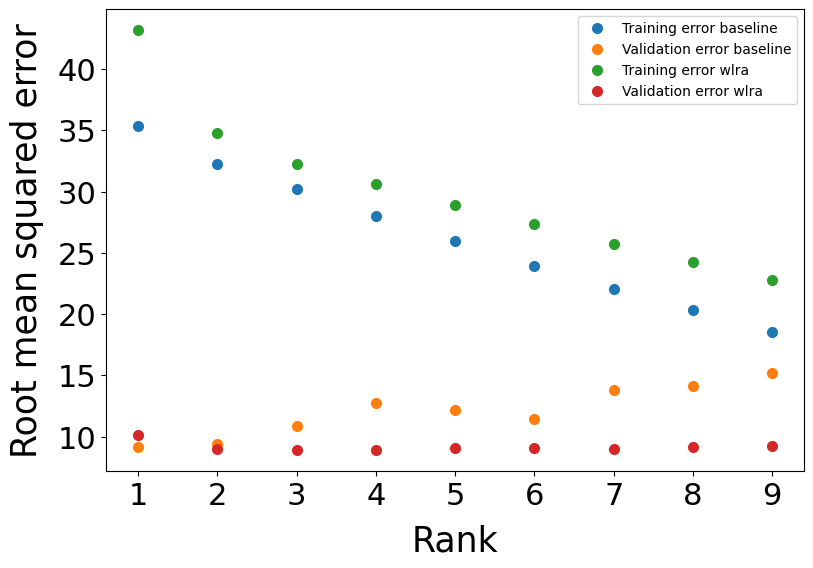

In [99]:
markersize = 10
plt.figure(figsize=(9,6))
plt.plot(ranks,train_error_base,linestyle="None",marker='o',markeredgewidth=2,label="Training error baseline")
plt.plot(ranks,val_error_base,linestyle="None",marker='o',markeredgewidth=2,label="Validation error baseline")
plt.plot(ranks,train_error_wlra,linestyle="None",marker='o',markeredgewidth=2,label="Training error wlra")
plt.plot(ranks,val_error_wlra,linestyle="None",marker='o',markeredgewidth=2,label="Validation error wlra")
plt.ylabel('Root mean squared error',fontsize=font_size,labelpad=10)
plt.xlabel('Rank',fontsize=font_size,labelpad=10)
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
#plt.ylim([0,1.1])
plt.legend()
# print(val_error)
plt.show()
# plt.savefig('collaborative_filtering_errors.pdf',bbox_inches="tight")

## (c) Evaluation
### What's the best rank (with least validation loss)? Report the test_error.

In [119]:
# baseline
best_rank = 1
estimate = fit_low_rank_model(best_rank,rating_matrix_ini,train_ind,train_ratings,n_iter,convergence_thresh,verbose)
test_error = np.linalg.norm(estimate.flat[test_ind] - test_ratings)
print("Error of low-rank estimate: " + str(np.round(test_error,3)))

Error of low-rank estimate: 8.81


In [115]:
best_rank = 2
estimate = X_lst[best_rank]
test_error = np.linalg.norm(estimate.flat[test_ind] - test_ratings)
print("Error of low-rank estimate: " + str(np.round(test_error,3)))

Error of low-rank estimate: 8.768


### If we estimate rating of each moive with the mean of its ratings (on training data), what's the test error? Compare with low rank model.

In [120]:
mean_rating_estimate = rating_matrix_ini
error_mean_rating = np.linalg.norm(mean_rating_estimate.flat[test_ind] - test_ratings)
print("Error of mean-movie estimate: " + str(np.round(error_mean_rating,3)))

Error of mean-movie estimate: 9.68
